In [1]:
import seaborn as sns
import sys
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import matplotlib
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from hyperopt import fmin, tpe, hp, Trials
from tensorflow.keras.optimizers import RMSprop

In [2]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to your file on Google Drive
file_path = '/content/drive/My Drive/output_file.csv'  # Replace with your file's path

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the data to verify it loaded correctly
print(data.head())


Mounted at /content/drive
   id   age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  50.0       2     168    62.0    110     80            1     1      0   
1   1  55.0       1     156    85.0    140     90            3     1      0   
2   2  52.0       1     165    64.0    130     70            3     1      0   
3   3  48.0       2     169    82.0    150    100            1     1      0   
4   4  48.0       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [3]:
# Rename columns
data.columns = ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

In [4]:
# Step 1: Data Preparation
X = np.array(data.drop(['cardio'], axis=1))  # Features
y = np.array(data['cardio'])  # Target

In [5]:
# Standardizing the data
mean = X.mean(axis=0)
X -= mean
std = X.std(axis=0)
X /= std

In [6]:
# Step 2: Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [7]:
# Convert target variable into categorical labels
Y_train = to_categorical(y_train, num_classes=None)
Y_test = to_categorical(y_test, num_classes=None)
print (Y_train.shape)
print (Y_train[:10])

(56000, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
# Build the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(8, activation='softmax'))
model.add(Dropout(0.3))

model.add(Dense(2, activation='sigmoid'))  # Final layer for binary classification

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping to avoid overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Fit the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, Y_test),
                    callbacks=[es], verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6460 - loss: 0.6370 - val_accuracy: 0.7278 - val_loss: 0.5593
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7127 - loss: 0.5842 - val_accuracy: 0.7288 - val_loss: 0.5683
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7232 - loss: 0.5732 - val_accuracy: 0.7274 - val_loss: 0.5683
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7186 - loss: 0.5761 - val_accuracy: 0.7380 - val_loss: 0.5490
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7190 - loss: 0.5726 - val_accuracy: 0.7310 - val_loss: 0.5594
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7225 - loss: 0.5703 - val_accuracy: 0.7251 - val_loss: 0.5594
Epoch 7/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7205 - loss: 0.5713 - val_accuracy: 0.7328 - val_loss: 0.5523
Epoch 8/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7219 - lo

In [9]:
# Get predictions and evaluate the model
categorical_pred = np.argmax(model.predict(X_test), axis=1)
y_test_int = np.argmax(Y_test, axis=1)

# Print results
print('Results for Categorical Model')
print(f"Accuracy: {accuracy_score(y_test_int, categorical_pred)}")
print(classification_report(y_test_int, categorical_pred))

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Results for Categorical Model
Accuracy: 0.7262142857142857
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      6988
           1       0.70      0.79      0.74      7012

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000



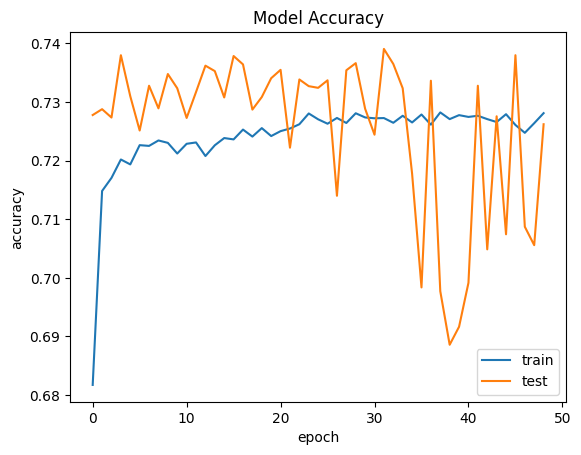

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

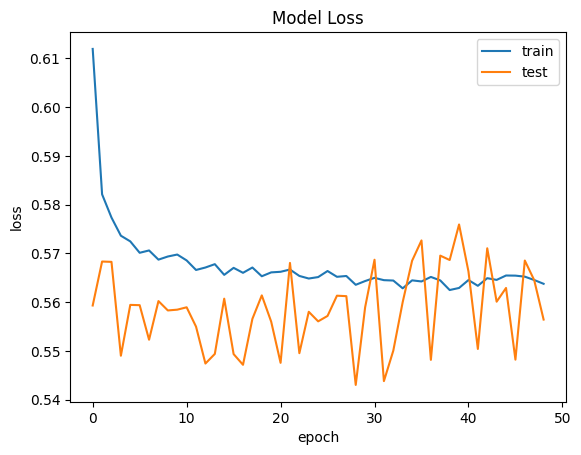

In [11]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.show()